In [1]:
import numpy as np
import os
from scipy.linalg import schur
import tensorflow as tf
from backend.networks import Model
import backend as be
from backend.simulation_tools import Simulator
from backend.weight_initializer import weight_initializer
from tasks import rule_dependent_rdm as rd
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
def run_trial_batch(data,w,sim):
    s = np.zeros([data[0].shape[1],data[0].shape[0],w['W_rec'].shape[0]])
    for kk in range(data[0].shape[0]):
        s[:,kk,:] = sim.run_trial(data[0][kk,:,:],t_connectivity=False)[1].reshape([data[0].shape[1],w['W_rec'].shape[0]])
        
    return s

def relu(x):
    return np.maximum(x,0)

def state_to_out(s,w):
    return relu(s).dot(w['W_out'].T) + w['b_out']

def linear_model(X,Y,lam=.1):
    return np.linalg.inv(X.T.dot(X) + lam*np.eye(X.shape[1])).dot(X.T).dot(Y)


def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

def plot_by_max(state,norm=True,thresh=.001):
    fr = np.maximum(state,thresh)
    if norm:
#         fr = ((fr-np.mean(fr,axis=0))/np.std(fr,axis=0))
        fr = ((fr-np.min(fr,axis=0))/(1e-10+np.max(fr,axis=0)-np.min(fr,axis=0)))
    idx = np.argsort(np.argmax(fr,axis=0))
    plt.pcolormesh(fr[:,idx].T)
    plt.colorbar()
    plt.xlim([0,np.shape(fr)[0]])

In [3]:
#stokes analysis

def fisher_z(r):
    return np.arctanh(r)

def pairwise_difference(data,t):
    N,M,T = data.shape
    pairs = (M**2-M)/2

    pwd = np.zeros([N,pairs])

    count = 0
    for ii in range(M):
        for jj in range(ii+1,M):
            pwd[:,count] = data[:,jj,t]-data[:,ii,t]
            count+=1
            
    return pwd

def pwd_similarity(pwd1,pwd2):
    pairs = pwd1.shape[1]
    correlations = np.diag(np.corrcoef(pwd1.T,pwd2.T)[pairs:,:pairs])
    
    mean_z_correlations = np.mean(fisher_z(correlations))
    mean_r = np.tanh(mean_z_correlations)
    
    return mean_r

def multivariate_similarity_analysis(data):
    N,M,T = data.shape #N = neurons, M = conditions, T = timesteps
    pairs = (M**2-M)/2
    pwds = np.zeros([N,pairs,T])
    for ii in range(T):
        pwds[:,:,ii] = pairwise_difference(data,ii)
    

    sims = np.zeros([T,T])
    for ii in range(T):
        for jj in range(T):
            sims[ii,jj] = pwd_similarity(pwds[:,:,ii],pwds[:,:,jj])

    return sims

In [12]:
n_rules = 2 #n_in = n_rules*2
n_hidden  = 100
n_out = 2
tau = 100.0 #As double
dt = 20.0  #As double
dale_ratio = None
rec_noise = 0.1
stim_noise = 0.1
batch_size = 128

cohs = [.05,.1,.3,.7,1.]
rt_version = False

#train params
learning_rate = .0005
training_iters = 50000
display_step = 50

weights_path = '../weights/rule_rdm_bff.npz'
#weights_path = None

params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
                    stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
                    L2_firing_rate = 0, sample_size = 128, epochs = 100, N_rec = n_hidden, 
                    dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = rd.generate_train_trials(params)

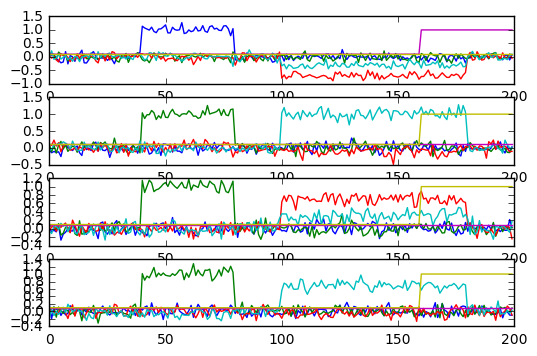

In [13]:
trial = rd.build_train_trials(params)

for ii in range(4):
    plt.subplot(4,1,ii+1)
    plt.plot(trial[0][ii,:,:])
    plt.plot(trial[1][ii,:,:])
plt.show()

In [9]:
# output_weights_path = weights_path
# params['init_type'] = 'gaussian'
# 'external weight intializer class'
# autapses = True
# w_initializer = weight_initializer(params,output_weights_path[:-4] + '_init',autapses=autapses)
# input_weights_path = w_initializer.gen_weight_dict()
# params['load_weights_path'] = input_weights_path + '.npz'


# w_init = np.load(input_weights_path + '.npz')

# plt.imshow(w_init['W_rec'],interpolation='none')

# plt.figure()
# plt.plot(w_init['W_in'])
# plt.show()


In [11]:

model = Model(params)
sess = tf.Session()
model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
            save_weights_path = weights_path, display_step=display_step)

sess.close()

Iter 3200, Minibatch Loss= 0.078477
Iter 6400, Minibatch Loss= 0.074648
Iter 9600, Minibatch Loss= 0.073821
Iter 12800, Minibatch Loss= 0.072878
Iter 16000, Minibatch Loss= 0.065299
Iter 19200, Minibatch Loss= 0.059832
Iter 22400, Minibatch Loss= 0.054569
Iter 25600, Minibatch Loss= 0.052692
Iter 28800, Minibatch Loss= 0.048837
Iter 32000, Minibatch Loss= 0.046054
Iter 35200, Minibatch Loss= 0.045307
Iter 38400, Minibatch Loss= 0.043448
Iter 41600, Minibatch Loss= 0.043971
Iter 44800, Minibatch Loss= 0.045111
Iter 48000, Minibatch Loss= 0.042022
Optimization Finished!


AttributeError: 'Model' object has no attribute 'input_Connectivity'

In [23]:
w = np.load(weights_path)

#test params
cohs = [.02]
sample_size = 500
rec_noise = .0#.1
stim_noise = .0#.1

params = rd.set_params(n_rules = n_rules, n_out = n_out, n_steps = 200, coherences=cohs, 
                    stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
                    L2_firing_rate = 0, sample_size = sample_size, epochs = 100, N_rec = n_hidden, 
                    dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version)

generator = rd.generate_train_trials(params)

sim = Simulator(params, weights_path=weights_path)

data = generator.next()

s = run_trial_batch(data,w,sim)

o = np.zeros([s.shape[0],s.shape[1],n_out])
for ii in range(data[0].shape[0]):
    o[:,ii,:] = state_to_out(s[:,ii,:],w)
    
    
rule = data[0][:,50,0]>.5
choice = np.argmax(o[-1,:,:],axis=1)
target = np.argmax(data[1][:,180,:],axis=1)
correct = choice == target

print 'performance = ' + str(np.mean(correct)*100) + '%'

performance = 100.0%


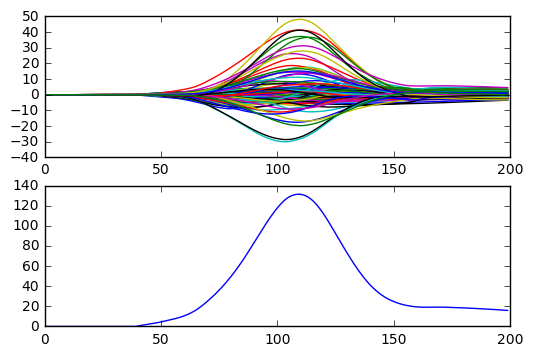

In [24]:
rule_diff = np.mean(s[:,rule==0,:],axis=1)-np.mean(s[:,rule==1,:],axis=1)

plt.subplot(2,1,1)
plt.plot(rule_diff)
plt.subplot(2,1,2)
plt.plot(np.sqrt(np.sum(rule_diff**2,axis=1)))
# plt.plot(np.mean(s[:,rule==1,:],axis=1))
plt.show()

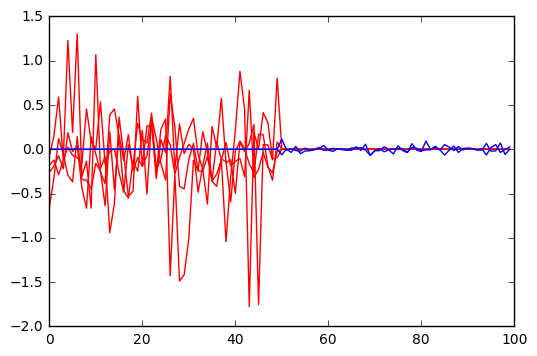

In [25]:
plt.plot(w['W_in'],'r')
plt.plot(w['W_out'].T,'b')
plt.show()

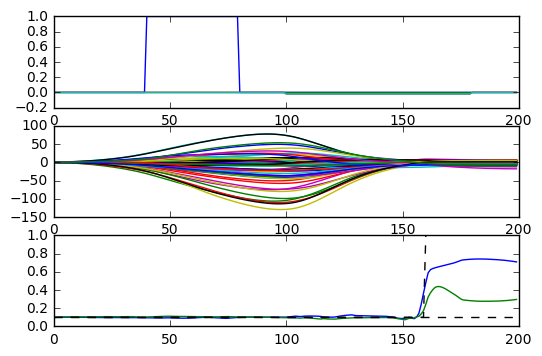

In [26]:
trial = 6
plt.subplot(3,1,1)
plt.plot(data[0][trial,:,:])

plt.subplot(3,1,2)
plt.plot(s[:,trial,:])

plt.subplot(3,1,3)
plt.plot(state_to_out(s[:,trial,:],w))
plt.plot(data[1][trial,:,:],'k--')

plt.show()

(200, 500, 100)

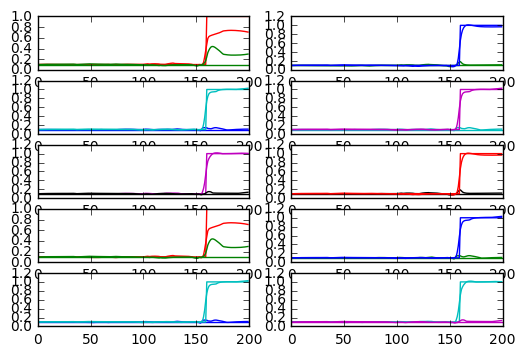

In [27]:
colors = ['r','g','b','c','m','k']*5
for ii in range(10):
    plt.subplot(5,2,ii+1)
    plt.plot(state_to_out(s[:,ii,:],w)[:,0],colors[ii])
    plt.plot(data[1][ii,:,0],colors[ii])
    
    plt.plot(state_to_out(s[:,ii,:],w)[:,1],colors[ii+1])
    plt.plot(data[1][ii,:,1],colors[ii+1])
    
s.shape

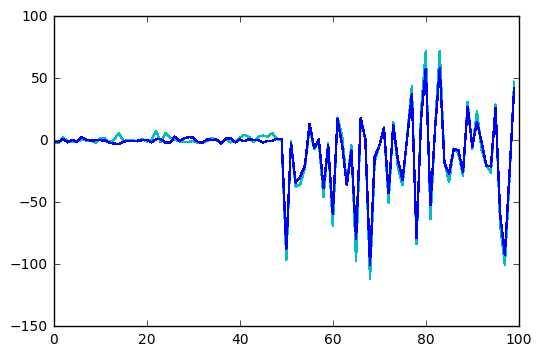

In [28]:
'''post rule cue activity'''

rule1 = data[0][:,50,0]>.5

plt.plot(s[80,rule1,:].T,'-c')
plt.plot(s[80,~rule1,:].T,'-b')
plt.show()

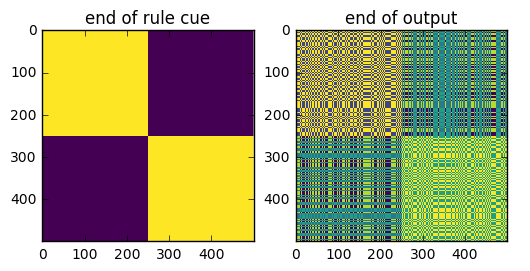

In [29]:
'''correlation of activity after rule cue, sorted by rule'''
plt.subplot(1,2,1)
plt.imshow(np.corrcoef(s[80,np.argsort(rule1),:]),interpolation='none')
plt.title('end of rule cue')
plt.subplot(1,2,2)
plt.imshow(np.corrcoef(s[-1,np.argsort(rule1),:]),interpolation='none')
plt.title('end of output')
plt.show()

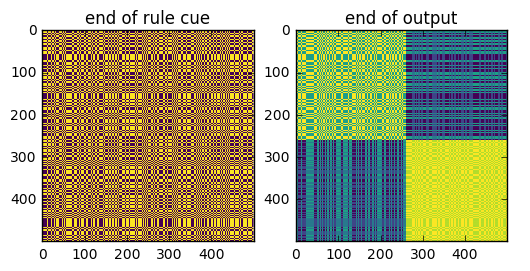

In [30]:
'''correlation of activity at trial end, sorted by target'''

plt.subplot(1,2,1)
plt.imshow(np.corrcoef(s[80,np.argsort(target),:]),interpolation='none')
plt.title('end of rule cue')
plt.subplot(1,2,2)
plt.imshow(np.corrcoef(s[-1,np.argsort(target),:]),interpolation='none')
plt.title('end of output')
plt.show()

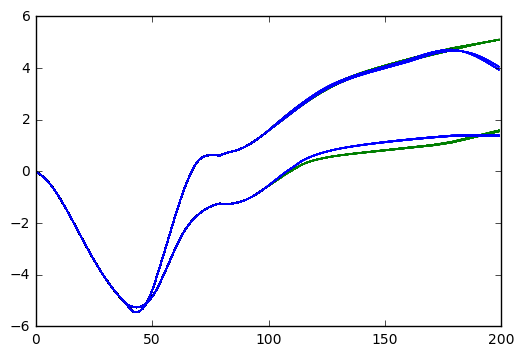

In [31]:
plt.plot(s[:,target==0,4],'g',alpha=.2)
plt.plot(s[:,target==1,4],'b',alpha=.2)
plt.show()

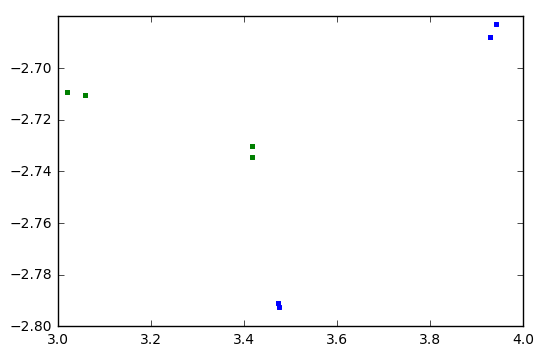

In [32]:
neurons = np.random.randint(n_hidden,size=2)
timepoint = 199

plt.plot(s[timepoint,np.logical_and(target==0,correct),neurons[0]],s[timepoint,np.logical_and(target==0,correct),neurons[1]],'.g',alpha=.5)
plt.plot(s[timepoint,np.logical_and(target==0,~correct),neurons[0]],s[timepoint,np.logical_and(target==0,~correct),neurons[1]],'xr',alpha=1)

plt.plot(s[timepoint,np.logical_and(target==1,correct),neurons[0]],s[timepoint,np.logical_and(target==1,correct),neurons[1]],'.b',alpha=.5)
plt.plot(s[timepoint,np.logical_and(target==1,~correct),neurons[0]],s[timepoint,np.logical_and(target==1,~correct),neurons[1]],'xk',alpha=1)
plt.show()

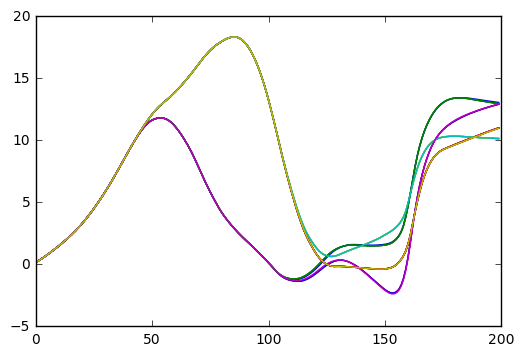

In [33]:
X = np.mean(s[120:140,:,:],axis=0)
Y = choice.reshape(500,1)

c = np.linalg.inv(X.T.dot(X) + np.eye(n_hidden)).dot(X.T).dot(Y)

for ii in range(20):
    plt.plot(s[:,ii,:].dot(c))
plt.show()

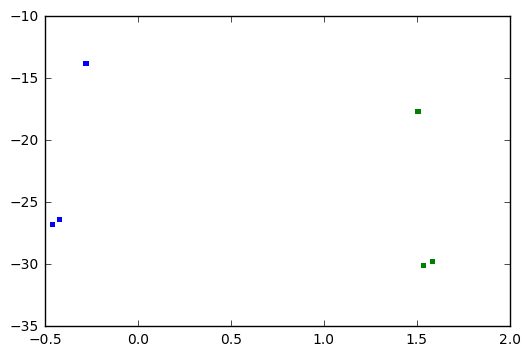

In [34]:
'''state projected onto linear readout for choice and random readout'''

r = np.random.randn(100,1)

timepoint = 140

plt.plot(s[timepoint,np.logical_and(target==0,correct),:].dot(c),s[timepoint,np.logical_and(target==0,correct),:].dot(r),'b.')
plt.plot(s[timepoint,np.logical_and(target==0,~correct),:].dot(c),s[timepoint,np.logical_and(target==0,~correct),:].dot(r),'rx')

plt.plot(s[timepoint,np.logical_and(target==1,correct),:].dot(c),s[timepoint,np.logical_and(target==1,correct),:].dot(r),'g.')
plt.plot(s[timepoint,np.logical_and(target==1,~correct),:].dot(c),s[timepoint,np.logical_and(target==1,~correct),:].dot(r),'kx')

/Users/daniel/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


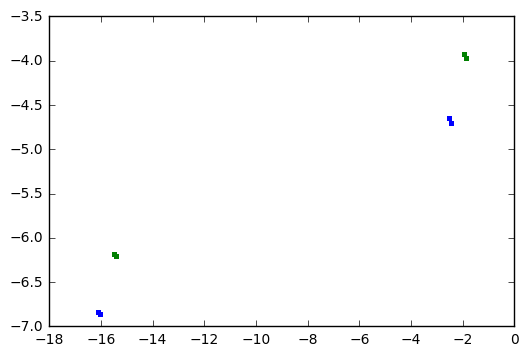

[-0.47491831+0.j -0.19662215+0.j]
[-0.10810342+0.j  0.22423682+0.j]
[[  4.60107946   1.65535247  -0.46369222   1.08820164]
 [  1.65535247   4.55022907   0.88446838  -2.62765956]
 [ -0.46369222   0.88446838  13.13464928  -0.24485651]
 [  1.08820164  -2.62765956  -0.24485651  14.88650703]]
(0.248178+0.170277j)


In [35]:
'''search for integrative modes'''

state_rule0 = np.mean(s[99,rule==0,:].T,axis=1)
state_rule1 = np.mean(s[99,rule==1,:].T,axis=1)

e_rule0 = np.linalg.eig(w['W_rec']*(state_rule0>0))
e_rule1 = np.linalg.eig(w['W_rec']*(state_rule1>0))

sorted_evals0 = np.argsort(np.abs(1-e_rule0[0].real))

sorted_evals1 = np.argsort(np.abs(1-e_rule1[0].real))

dom_mode0 = e_rule0[1][sorted_evals0[0]]
dom_mode1 = e_rule1[1][sorted_evals1[0]]

plt.plot(s[140,np.logical_and(target==0,correct),:].dot(dom_mode0),s[140,np.logical_and(target==0,correct),:].dot(dom_mode1),'b.')
plt.plot(s[140,np.logical_and(target==0,~correct),:].dot(dom_mode0),s[140,np.logical_and(target==0,~correct),:].dot(dom_mode1),'rx')

plt.plot(s[140,np.logical_and(target==1,correct),:].dot(dom_mode0),s[140,np.logical_and(target==1,correct),:].dot(dom_mode1),'g.')
plt.plot(s[140,np.logical_and(target==1,~correct),:].dot(dom_mode0),s[140,np.logical_and(target==1,~correct),:].dot(dom_mode1),'kx')
plt.show()

print w['W_in'][:,2:].T.dot(dom_mode0)
print w['W_in'][:,2:].T.dot(dom_mode1)

print w['W_in'].T.dot(w['W_in'])

print dom_mode0.dot(dom_mode1)




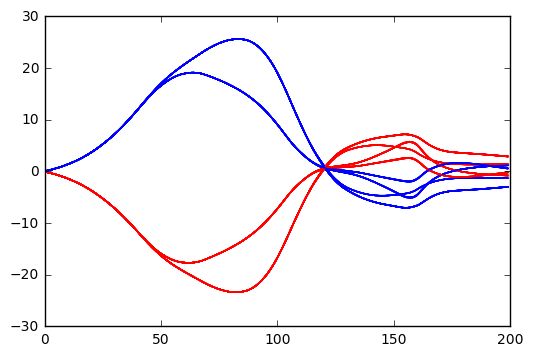

In [36]:
'''projection target'''

target0 = data[1][:,-1,0]
target1 = data[1][:,-1,1]

X = np.mean(s[100:160,:,:],axis=0)
Y0 = target0.reshape(500,1)
Y1 = target1.reshape(500,1)

c0 = np.linalg.inv(X.T.dot(X) + .1*np.eye(n_hidden)).dot(X.T).dot(Y0)
c1 = np.linalg.inv(X.T.dot(X) + .1*np.eye(n_hidden)).dot(X.T).dot(Y1)

for ii in range(50):
    plt.plot(s[:,ii,:].dot(c0),'r')
    plt.plot(s[:,ii,:].dot(c1),'b')
plt.show()

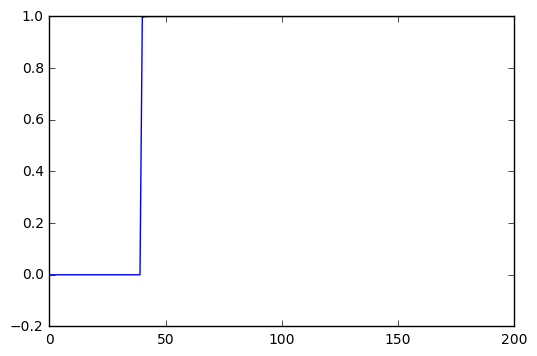

In [37]:
'''diff rules along optimal over time'''

xx = range(0,200,1)
diff_rule = np.zeros(len(xx))

for ii,tt in enumerate(xx):
    
    X = np.hstack([np.ones([s.shape[1],1]),s[tt,:,:]])
    
    w_hat = linear_model(X,(rule.astype(int)).reshape(500,1),lam=.1)
    y_hat = (X.dot(w_hat)).T
    

#     w_hat = linear_model(s[tt,:,:],(rule.astype(int)).reshape(500,1),lam=.1)
#     y_hat = (s[tt,:,:].dot(w_hat)).T
    
    diff_rule[ii] = np.mean(y_hat.T[rule])-np.mean(y_hat.T[~rule])

#     plt.hist(y_hat.T[rule],alpha=.2)
#     plt.hist(y_hat.T[~rule],alpha=.2)
#     plt.show()

plt.plot(diff_rule)
plt.show()

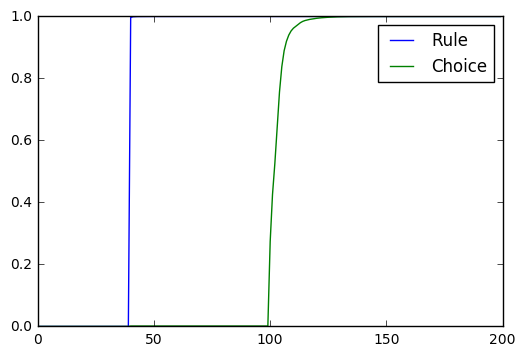

In [38]:
'''diff choice along optimal over time'''

xx = range(0,200,1)
diff_choice = np.zeros(len(xx))

for ii,tt in enumerate(xx):
    
    X = np.hstack([np.ones([s.shape[1],1]),s[tt,:,:]])
    
    w_hat = linear_model(X,(choice.astype(int)).reshape(500,1),lam=.1)
    y_hat = (X.dot(w_hat)).T

#     w_hat = linear_model(s[tt,:,:],(choice.astype(int)).reshape(500,1),lam=.1)
#     y_hat = (s[tt,:,:].dot(w_hat)).T
    
    diff_choice[ii] = np.mean(y_hat.T[choice==1])-np.mean(y_hat.T[choice==0])

#     plt.hist(y_hat.T[rule],alpha=.2)
#     plt.hist(y_hat.T[~rule],alpha=.2)
#     plt.show()

plt.plot(normalize(diff_rule))
plt.plot(normalize(diff_choice))
plt.legend(['Rule','Choice'],loc=0)

plt.show()

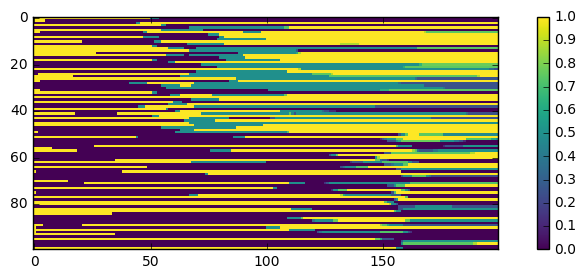

In [39]:
'''Percentage of trials for which neuron is on at timepoint t'''

plt.figure(figsize=(10,3))
plt.imshow(np.mean(s[:,:,:]>0,axis=1).T,interpolation='none')
plt.colorbar()
plt.show()

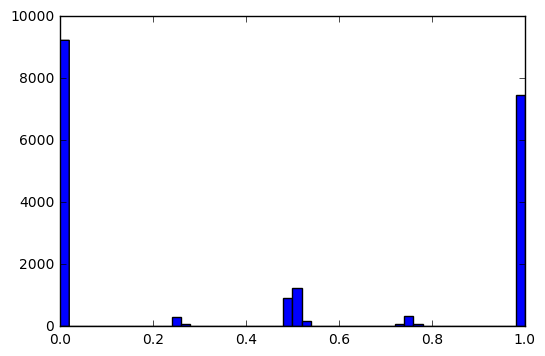

In [40]:
'''density of neuron "on"'''

plt.hist(np.mean(s[:,:,:]>0,axis=1).flatten(),50)
plt.show()

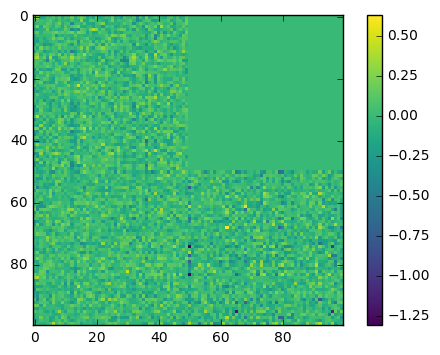

0.0262574
0.0156787
0.0
0.0180281


In [41]:
plt.imshow(w['W_rec'],interpolation='none')#,vmin=-.1,vmax=.1)
plt.colorbar()
plt.show()

N2 = n_hidden//2

print np.mean(w['W_rec'][N2:,N2:]**2)
print np.mean(w['W_rec'][N2:,:N2]**2)
print np.mean(w['W_rec'][:N2,N2:]**2)
print np.mean(w['W_rec'][:N2,:N2]**2)

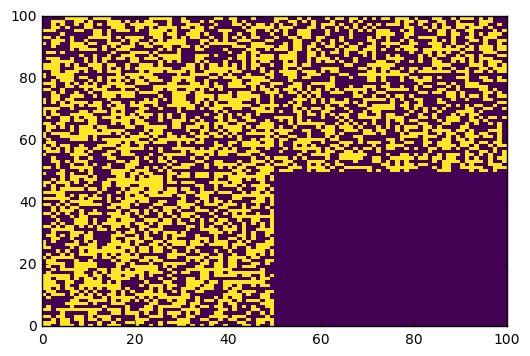

In [42]:
plt.pcolor(w['W_rec']>0)
plt.show()

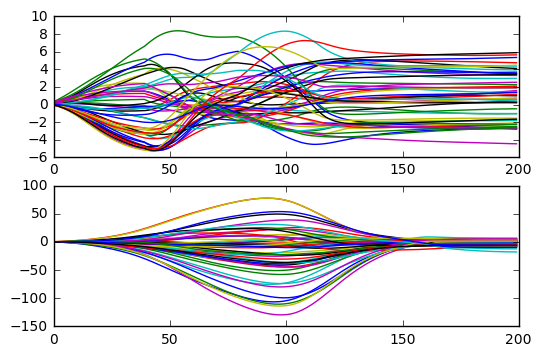

(200, 500, 100)

In [43]:
plt.subplot(2,1,1)
plt.plot(s[:,0,:50])
plt.subplot(2,1,2)
plt.plot(s[:,0,50:])
plt.show()
s.shape

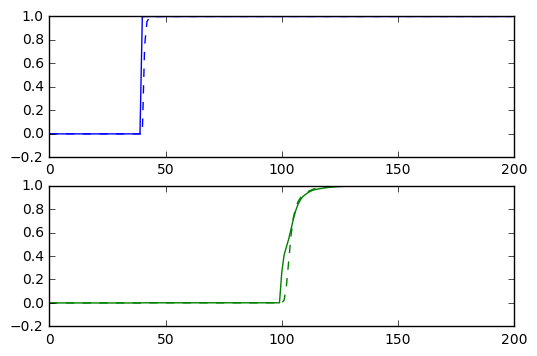

In [44]:
'''diff rules along optimal over time'''

def plot_rule_choice(s,rule,choice):

    xx = range(0,200,1)
    diff_rule = np.zeros(len(xx))
    diff_choice = np.zeros(len(xx))
    
    y_hat_rule = []
    y_hat_choice = []

    for ii,tt in enumerate(xx):

        X = np.hstack([np.ones([s.shape[1],1]),s[tt,:,:]])

        #fit to rule
        
        w_hat = linear_model(X,(rule.astype(int)).reshape(500,1),lam=.1)
        y_hat = (X.dot(w_hat)).T
        
        y_hat_rule.append(y_hat)

        diff_rule[ii] = np.mean(y_hat.T[rule])-np.mean(y_hat.T[~rule])

        
        #fit choice

        w_hat = linear_model(X,(choice.astype(int)).reshape(500,1),lam=.1)
        y_hat = (X.dot(w_hat)).T
        
        y_hat_choice.append(y_hat)

        diff_choice[ii] = np.mean(y_hat.T[choice==1])-np.mean(y_hat.T[choice==0])


#     plt.plot(1-normalize(diff_rule))
#     plt.plot(1-normalize(diff_choice))
#     plt.legend(['Rule','Choice'],loc=0)
    
    return diff_rule, diff_choice, y_hat_rule, y_hat_choice

dr0,dc0, yhr0,yhc0 = plot_rule_choice(s[:,:,:50],rule,choice)
dr1,dc1, yhr1,yhc1 = plot_rule_choice(s[:,:,50:],rule,choice)

plt.subplot(2,1,1)
plt.plot(dr0,'b')
plt.plot(dr1,'b--')
plt.subplot(2,1,2)
plt.plot(dc0,'g')
plt.plot(dc1,'g--')


plt.show()



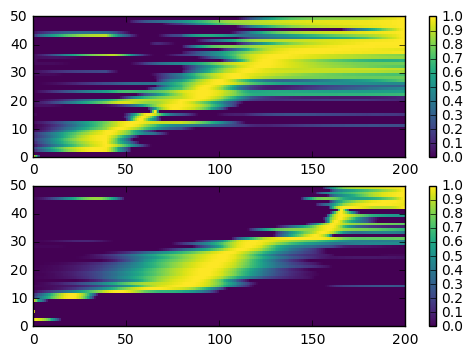

In [45]:
plt.subplot(2,1,1)
plot_by_max(s[:,0,:50])
plt.subplot(2,1,2)
plot_by_max(s[:,0,50:])
plt.show()

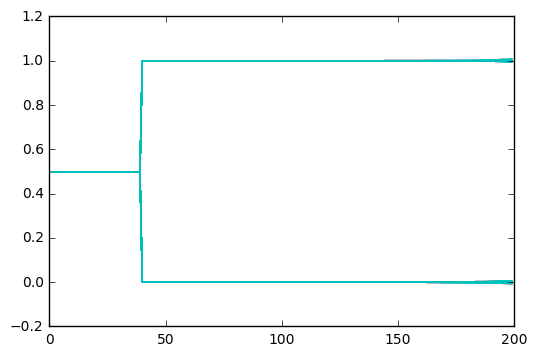

(1, 500)

In [46]:
plt.plot(np.asarray(yhr0).reshape([200,500]),'c',alpha=.04)
plt.show()

y_hat.shape

In [47]:
mu_rule = np.stack([np.mean(s[:,rule,:],axis=1),np.mean(s[:,~rule,:],axis=1)],2)
mu_rule = np.transpose(mu_rule,[1,2,0])

mu_choice = np.stack([np.mean(s[:,choice==0,:],axis=1),np.mean(s[:,choice==1,:],axis=1)],2)
mu_choice = np.transpose(mu_choice,[1,2,0])

mu_target = np.stack([np.mean(s[:,target==0,:],axis=1),np.mean(s[:,target==1,:],axis=1)],2)
mu_target = np.transpose(mu_target,[1,2,0])

In [48]:
simr = multivariate_similarity_analysis(mu_rule)
simc = multivariate_similarity_analysis(mu_choice)
simt = multivariate_similarity_analysis(mu_target)

/Users/daniel/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in arctanh


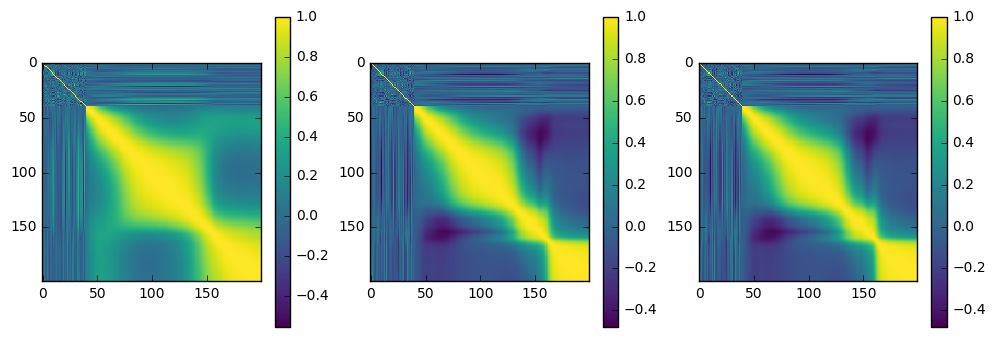

In [49]:
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(simr,interpolation='none')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(simc,interpolation='none')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(simt,interpolation='none')
plt.colorbar()
plt.show()

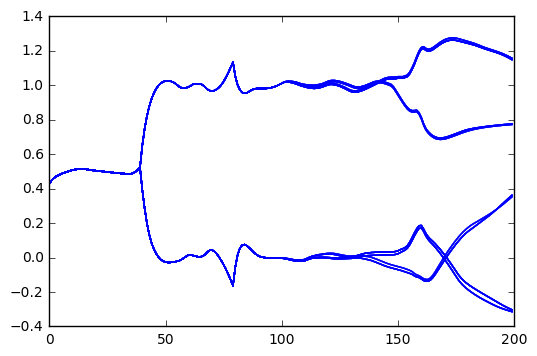

In [50]:
X = mu_rule.reshape([100,400]).T
Y = np.zeros([400,1])
# Y[:300] = 1
# Y[100:200] = -1
Y[:200] = 1.

w = linear_model(X,Y,lam=.5)

colors = ['r','b']

for ii in range(200):
    plt.plot(s[:,ii,:].dot(w),c = colors[int(correct[ii])],alpha=.2)

plt.show()

In [51]:
mu_choice.shape

(100, 2, 200)